# Google Colab specific

## Check if Google Colab is using TPUs

In [1]:
from os import environ
if 'COLAB_TPU_ADDR' not in environ:
  print('Not connected to a TPU runtime.')
else:
  tpu_address = 'grpc://' + environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

TPU address is grpc://10.15.119.202:8470


## Install TPU client and torch xla if TPUs are used

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl

## Clone github repo containing source code of the model

In [ ]:
!rm -rf *
!git clone https://github.com/karabellyj/KNN2021-LM
!cp -r KNN2021-LM/* .

## Mount Google drive to be able to save and load trained models 

In [ ]:
from google.colab import drive
drive.mount('/drive')

# Install Pytorch Lightning and some helper huggingface libraries

In [ ]:
!pip3 install pytorch-lightning
!pip3 install tokenizers datasets

# Import libraries neccesary for model creation and training

In [3]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl

from data import WikiText2DataModule
from models.transformer import LMModel

# Set global random *seed*

In [4]:
pl.seed_everything(58)

Global seed set to 58


58

# Initialize data mudule and callbacks

## Checkpoints

In [9]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='gpt-{epoch}-{step}',
    save_top_k=3,
    mode='min',
)
early_stop_callback = EarlyStopping(
    monitor='perplexity',
    min_delta=0.00,
    patience=5,
    verbose=False,
    mode='min'
)

## Data module

In [ ]:
data_module = WikiText2DataModule(
    train_batch_size=64,
    val_batch_size=64,
    seq_length= 64,
    vocab_size=15000
)
data_module.prepare_data()

# Select logdir for Pytorch Lightning

In [4]:
logdir_path = 'example/'

# Create new model, or below ...

In [20]:
model = LMModel(
    vocab_size=data_module.tokenizer.get_vocab_size(),
    d_model= 128,
    n_layers= 2,
    n_heads= 4,
    d_ff= 512,
    attention='performer'
)

# ... select model from a checkpoint

In [2]:
from os import listdir
from os.path import join, basename

def latest_model_path(model_version='version_0'):
  global logdir_path
  checkpoints_path = join(logdir_path, 'lightning_logs' , model_version, 'checkpoints')
  print("Checkpoints path:", checkpoints_path)
  checkpoints = listdir(checkpoints_path)
  steps_of_checkpoints = [float(f.rsplit('.',1)[0].split('=')[-1]) for f in checkpoints]
  assert len(steps_of_checkpoints) > 0, 'Checkpoints directory cannot be empty'
  
  latest_checkpoint = checkpoints[steps_of_checkpoints.index(max(steps_of_checkpoints))]
  print("Latest Checkpoint:", latest_checkpoint)

  return join(logdir_path,'lightning_logs', model_version, 'checkpoints' , latest_checkpoint), join(logdir_path,'lightning_logs', model_version, 'hparams.yaml')

## Load best model

In [14]:
latest_model_checkpoint, latest_model_hparams = latest_model_path('version_0')
model = LMModel.load_from_checkpoint(checkpoint_path=latest_model_checkpoint, hparams_file=latest_model_hparams)

Checkpoints path: /drive/MyDrive/KNN/lightning_logs/version_0/checkpoints
Latest Checkpoint: gpt-epoch:0-val_loss:6.0.ckpt


# Setup a trainer

In [ ]:
trainer = pl.Trainer(
    #resume_from_checkpoint=latest_model_checkpoint,
    callbacks=[checkpoint_callback], 
    max_epochs=24, 
    val_check_interval=500, 
    default_root_dir=logdir_path,
    #gpus=1,
    tpu_cores=8,
)

In [2]:
%reload_ext tensorboard
%tensorboard --logdir /drive/MyDrive/KNN/lightning_logs/

# Train model

In [ ]:
trainer.fit(model=model, datamodule=data_module)

# Inference

In [1]:
from inference import inference

In [114]:
latest_model_checkpoint, latest_model_hparams = latest_model_path('version_75')

input = 'In 1691 Moscow established the'

output, tokens, attn = inference(
    latest_model_checkpoint, latest_model_hparams, 
    'example/lightning_logs/wiki-vocab.json', 'example/lightning_logs/wiki-merges.txt', 
    input=input, 
    generated_length=5
)

print('Params:', open(latest_model_hparams,'r').read(), sep='\n')

Checkpoints path: example/lightning_logs/version_75/checkpoints
Latest Checkpoint: epoch=4-step=138963.ckpt
Params:
attention: default
attn_pdrop: 0.1
d_ff: 512
d_model: 128
embd_pdrop: 0.1
n_heads: 4
n_layers: 2
pad_id: 0
resid_pdrop: 0.1
vocab_size: 30000



In [115]:
print("========================\n          INPUT         \n========================")
print(input)
print("========================\n         OUTPUT         \n========================")
print(output)
print(tokens)


          INPUT         
In 1691 Moscow established the
         OUTPUT         
 In 1691 Moscow established the city 's economy ,
['ĠIn', 'Ġ169', '1', 'ĠMoscow', 'Ġestablished', 'Ġthe', 'Ġcity', "Ġ'", 's', 'Ġeconomy', 'Ġ,']


In [124]:
import matplotlib.pyplot as plt
def plot_attention(attn, tokens):
    fig, ax = plt.subplots(len(attn), attn[0][0].shape[0], figsize=(20,10))
    for layer in range(len(attn)):
        #ax = [ax[x,y] for x in range(len(ax)) for y in range(len(ax[0])) ]
        for head in range(attn[layer][0].shape[0]):
            ax[layer][head].imshow(attn[layer][0][head].detach())
            ax[layer][head].xaxis.set_ticks(range(len(tokens) - 1))
            ax[layer][head].xaxis.set_ticklabels(tokens[:-1])
            ax[layer][head].xaxis.set_tick_params(labelrotation=60, labelbottom=True, labeltop=False)
            ax[layer][head].yaxis.set_ticks(range(len(tokens) - 1))
            ax[layer][head].yaxis.set_ticklabels(tokens[:-1])
            ax[layer][head].set_title(f"Head {head}")

        fig.tight_layout()
    plt.savefig(f"AttentionWeights.pdf")


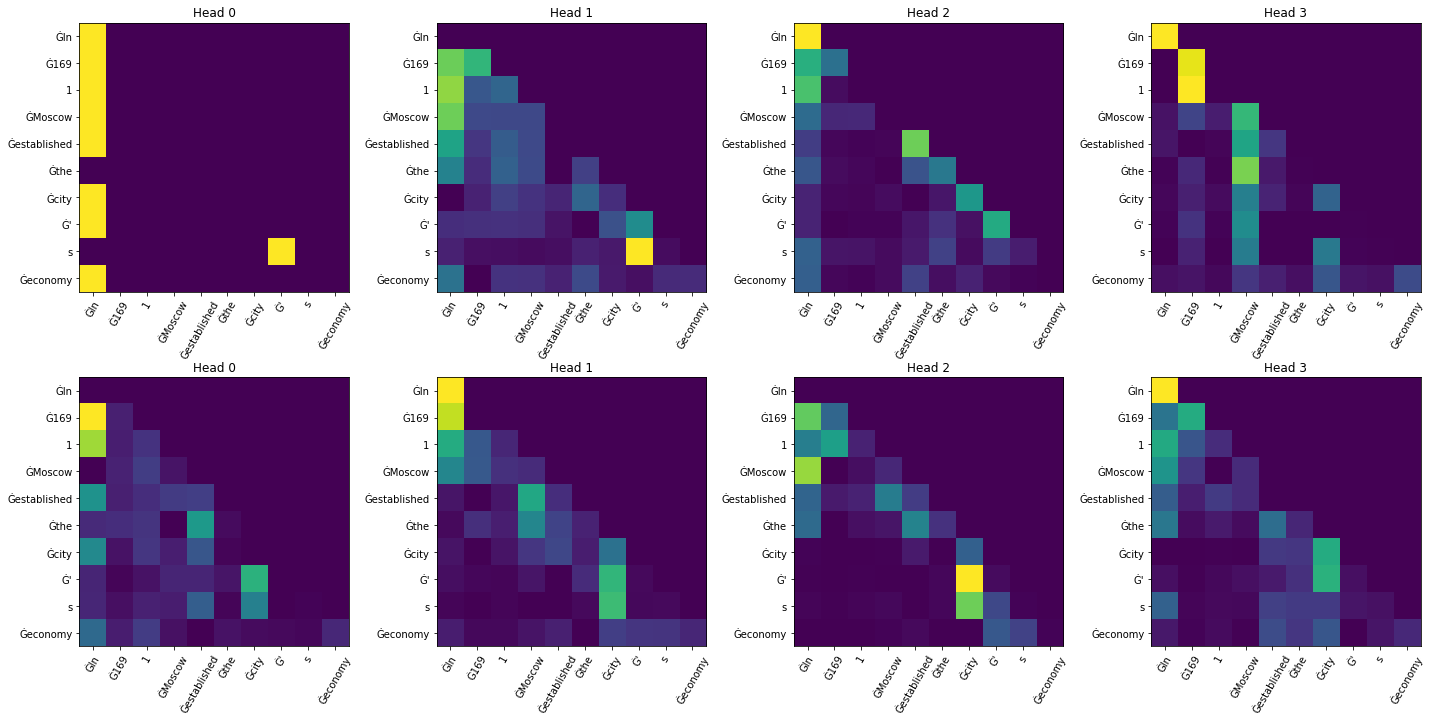

In [125]:
plot_attention(attn, tokens)

In [ ]:
!ls /drive/MyDrive/KNN/lightning_logs/version_0/checkpoints

In [ ]:
!ls /drive/MyDrive/KNN/lightning_logs/